In [1]:
#############################################################################
# 				Documentation				    #
#############################################################################

# Author:   Todd Whiteman
# Date:     16th March, 2009
# Verion:   2.0.0
# License:  Public Domain - free to do as you wish
# Homepage: http://twhiteman.netfirms.com/des.html
#
# This is a pure python implementation of the DES encryption algorithm.
# It's pure python to avoid portability issues, since most DES 
# implementations are programmed in C (for performance reasons).
#
# Triple DES class is also implemented, utilising the DES base. Triple DES
# is either DES-EDE3 with a 24 byte key, or DES-EDE2 with a 16 byte key.
#
# See the README.txt that should come with this python module for the
# implementation methods used.
#
# Thanks to:
#  * David Broadwell for ideas, comments and suggestions.
#  * Mario Wolff for pointing out and debugging some triple des CBC errors.
#  * Santiago Palladino for providing the PKCS5 padding technique.
#  * Shaya for correcting the PAD_PKCS5 triple des CBC errors.
#
"""A pure python implementation of the DES and TRIPLE DES encryption algorithms.

Class initialization
--------------------
pyDes.des(key, [mode], [IV], [pad], [padmode])
pyDes.triple_des(key, [mode], [IV], [pad], [padmode])

key     -> Bytes containing the encryption key. 8 bytes for DES, 16 or 24 bytes
	   for Triple DES
mode    -> Optional argument for encryption type, can be either
	   pyDes.ECB (Electronic Code Book) or pyDes.CBC (Cypher Block Chaining)
IV      -> Optional Initial Value bytes, must be supplied if using CBC mode.
	   Length must be 8 bytes.
pad     -> Optional argument, set the pad character (PAD_NORMAL) to use during
	   all encrypt/decrpt operations done with this instance.
padmode -> Optional argument, set the padding mode (PAD_NORMAL or PAD_PKCS5)
	   to use during all encrypt/decrpt operations done with this instance.

I recommend to use PAD_PKCS5 padding, as then you never need to worry about any
padding issues, as the padding can be removed unambiguously upon decrypting
data that was encrypted using PAD_PKCS5 padmode.

Common methods
--------------
encrypt(data, [pad], [padmode])
decrypt(data, [pad], [padmode])

data    -> Bytes to be encrypted/decrypted
pad     -> Optional argument. Only when using padmode of PAD_NORMAL. For
	   encryption, adds this characters to the end of the data block when
	   data is not a multiple of 8 bytes. For decryption, will remove the
	   trailing characters that match this pad character from the last 8
	   bytes of the unencrypted data block.
padmode -> Optional argument, set the padding mode, must be one of PAD_NORMAL
	   or PAD_PKCS5). Defaults to PAD_NORMAL.
	  

Example
-------
from pyDes import *

data = "Please encrypt my data"
k = des("DESCRYPT", CBC, "\0\0\0\0\0\0\0\0", pad=None, padmode=PAD_PKCS5)
# For Python3, you'll need to use bytes, i.e.:
#   data = b"Please encrypt my data"
#   k = des(b"DESCRYPT", CBC, b"\0\0\0\0\0\0\0\0", pad=None, padmode=PAD_PKCS5)
d = k.encrypt(data)
print "Encrypted: %r" % d
print "Decrypted: %r" % k.decrypt(d)
assert k.decrypt(d, padmode=PAD_PKCS5) == data


See the module source (pyDes.py) for more examples of use.
You can also run the pyDes.py file without and arguments to see a simple test.

Note: This code was not written for high-end systems needing a fast
      implementation, but rather a handy portable solution with small usage.

"""

import sys

# _pythonMajorVersion is used to handle Python2 and Python3 differences.
_pythonMajorVersion = sys.version_info[0]

# Modes of crypting / cyphering
ECB = 0
CBC = 1

# Modes of padding
PAD_NORMAL = 1
PAD_PKCS5 = 2


# PAD_PKCS5: is a method that will unambiguously remove all padding
#            characters after decryption, when originally encrypted with
#            this padding mode.
# For a good description of the PKCS5 padding technique, see:
# http://www.faqs.org/rfcs/rfc1423.html

# The base class shared by des and triple des.
class _baseDes(object):
    def __init__(self, mode=ECB, IV=None, pad=None, padmode=PAD_NORMAL):
        if IV:
            IV = self._guardAgainstUnicode(IV)
        if pad:
            pad = self._guardAgainstUnicode(pad)
        self.block_size = 8
        # Sanity checking of arguments.
        if pad and padmode == PAD_PKCS5:
            raise ValueError("Cannot use a pad character with PAD_PKCS5")
        if IV and len(IV) != self.block_size:
            raise ValueError("Invalid Initial Value (IV), must be a multiple of " + str(self.block_size) + " bytes")

        # Set the passed in variables
        self._mode = mode
        self._iv = IV
        self._padding = pad
        self._padmode = padmode

    def getKey(self):
        """getKey() -> bytes"""
        return self.__key

    def setKey(self, key):
        """Will set the crypting key for this object."""
        key = self._guardAgainstUnicode(key)
        self.__key = key

    def getMode(self):
        """getMode() -> pyDes.ECB or pyDes.CBC"""
        return self._mode

    def setMode(self, mode):
        """Sets the type of crypting mode, pyDes.ECB or pyDes.CBC"""
        self._mode = mode

    def getPadding(self):
        """getPadding() -> bytes of length 1. Padding character."""
        return self._padding

    def setPadding(self, pad):
        """setPadding() -> bytes of length 1. Padding character."""
        if pad is not None:
            pad = self._guardAgainstUnicode(pad)
        self._padding = pad

    def getPadMode(self):
        """getPadMode() -> pyDes.PAD_NORMAL or pyDes.PAD_PKCS5"""
        return self._padmode

    def setPadMode(self, mode):
        """Sets the type of padding mode, pyDes.PAD_NORMAL or pyDes.PAD_PKCS5"""
        self._padmode = mode

    def getIV(self):
        """getIV() -> bytes"""
        return self._iv

    def setIV(self, IV):
        """Will set the Initial Value, used in conjunction with CBC mode"""
        if not IV or len(IV) != self.block_size:
            raise ValueError("Invalid Initial Value (IV), must be a multiple of " + str(self.block_size) + " bytes")
        IV = self._guardAgainstUnicode(IV)
        self._iv = IV

    def _padData(self, data, pad, padmode):
        # Pad data depending on the mode
        if padmode is None:
            # Get the default padding mode.
            padmode = self.getPadMode()
        if pad and padmode == PAD_PKCS5:
            raise ValueError("Cannot use a pad character with PAD_PKCS5")

        if padmode == PAD_NORMAL:
            if len(data) % self.block_size == 0:
                # No padding required.
                return data

            if not pad:
                # Get the default padding.
                pad = self.getPadding()
            if not pad:
                raise ValueError("Data must be a multiple of " + str(
                    self.block_size) + " bytes in length. Use padmode=PAD_PKCS5 or set the pad character.")
            data += (self.block_size - (len(data) % self.block_size)) * pad

        elif padmode == PAD_PKCS5:
            pad_len = 8 - (len(data) % self.block_size)
            if _pythonMajorVersion < 3:
                data += pad_len * chr(pad_len)
            else:
                data += bytes([pad_len] * pad_len)

        return data

    def _unpadData(self, data, pad, padmode):
        # Unpad data depending on the mode.
        if not data:
            return data
        if pad and padmode == PAD_PKCS5:
            raise ValueError("Cannot use a pad character with PAD_PKCS5")
        if padmode is None:
            # Get the default padding mode.
            padmode = self.getPadMode()

        if padmode == PAD_NORMAL:
            if not pad:
                # Get the default padding.
                pad = self.getPadding()
            if pad:
                data = data[:-self.block_size] + \
                       data[-self.block_size:].rstrip(pad)

        elif padmode == PAD_PKCS5:
            if _pythonMajorVersion < 3:
                pad_len = ord(data[-1])
            else:
                pad_len = data[-1]
            data = data[:-pad_len]

        return data

    def _guardAgainstUnicode(self, data):
        # Only accept byte strings or ascii unicode values, otherwise
        # there is no way to correctly decode the data into bytes.
        if _pythonMajorVersion < 3:
            if isinstance(data, "unicode"):
                raise ValueError("pyDes can only work with bytes, not Unicode strings.")
        else:
            if isinstance(data, str):
                # Only accept ascii unicode values.
                try:
                    return data.encode('ascii')
                except UnicodeEncodeError:
                    pass
                raise ValueError("pyDes can only work with encoded strings, not Unicode.")
        return data


#############################################################################
# 				    DES					    #
#############################################################################
class des(_baseDes):
    """DES encryption/decrytpion class

    Supports ECB (Electronic Code Book) and CBC (Cypher Block Chaining) modes.

    pyDes.des(key,[mode], [IV])

    key  -> Bytes containing the encryption key, must be exactly 8 bytes
    mode -> Optional argument for encryption type, can be either pyDes.ECB
        (Electronic Code Book), pyDes.CBC (Cypher Block Chaining)
    IV   -> Optional Initial Value bytes, must be supplied if using CBC mode.
        Must be 8 bytes in length.
    pad  -> Optional argument, set the pad character (PAD_NORMAL) to use
        during all encrypt/decrpt operations done with this instance.
    padmode -> Optional argument, set the padding mode (PAD_NORMAL or
        PAD_PKCS5) to use during all encrypt/decrpt operations done
        with this instance.
    """

    # Permutation and translation tables for DES
    __pc1 = [56, 48, 40, 32, 24, 16, 8,
             0, 57, 49, 41, 33, 25, 17,
             9, 1, 58, 50, 42, 34, 26,
             18, 10, 2, 59, 51, 43, 35,
             62, 54, 46, 38, 30, 22, 14,
             6, 61, 53, 45, 37, 29, 21,
             13, 5, 60, 52, 44, 36, 28,
             20, 12, 4, 27, 19, 11, 3
             ]

    # number left rotations of pc1
    __left_rotations = [
        1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1
    ]

    # permuted choice key (table 2)
    __pc2 = [
        13, 16, 10, 23, 0, 4,
        2, 27, 14, 5, 20, 9,
        22, 18, 11, 3, 25, 7,
        15, 6, 26, 19, 12, 1,
        40, 51, 30, 36, 46, 54,
        29, 39, 50, 44, 32, 47,
        43, 48, 38, 55, 33, 52,
        45, 41, 49, 35, 28, 31
    ]

    # initial permutation IP
    __ip = [57, 49, 41, 33, 25, 17, 9, 1,
            59, 51, 43, 35, 27, 19, 11, 3,
            61, 53, 45, 37, 29, 21, 13, 5,
            63, 55, 47, 39, 31, 23, 15, 7,
            56, 48, 40, 32, 24, 16, 8, 0,
            58, 50, 42, 34, 26, 18, 10, 2,
            60, 52, 44, 36, 28, 20, 12, 4,
            62, 54, 46, 38, 30, 22, 14, 6
            ]

    # Expansion table for turning 32 bit blocks into 48 bits
    __expansion_table = [
        31, 0, 1, 2, 3, 4,
        3, 4, 5, 6, 7, 8,
        7, 8, 9, 10, 11, 12,
        11, 12, 13, 14, 15, 16,
        15, 16, 17, 18, 19, 20,
        19, 20, 21, 22, 23, 24,
        23, 24, 25, 26, 27, 28,
        27, 28, 29, 30, 31, 0
    ]

    # The (in)famous S-boxes
    __sbox = [
        # S1
        [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7,
         0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8,
         4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0,
         15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13],

        # S2
        [15, 1, 8, 14, 6, 11, 3, 4, 9, 7, 2, 13, 12, 0, 5, 10,
         3, 13, 4, 7, 15, 2, 8, 14, 12, 0, 1, 10, 6, 9, 11, 5,
         0, 14, 7, 11, 10, 4, 13, 1, 5, 8, 12, 6, 9, 3, 2, 15,
         13, 8, 10, 1, 3, 15, 4, 2, 11, 6, 7, 12, 0, 5, 14, 9],

        # S3
        [10, 0, 9, 14, 6, 3, 15, 5, 1, 13, 12, 7, 11, 4, 2, 8,
         13, 7, 0, 9, 3, 4, 6, 10, 2, 8, 5, 14, 12, 11, 15, 1,
         13, 6, 4, 9, 8, 15, 3, 0, 11, 1, 2, 12, 5, 10, 14, 7,
         1, 10, 13, 0, 6, 9, 8, 7, 4, 15, 14, 3, 11, 5, 2, 12],

        # S4
        [7, 13, 14, 3, 0, 6, 9, 10, 1, 2, 8, 5, 11, 12, 4, 15,
         13, 8, 11, 5, 6, 15, 0, 3, 4, 7, 2, 12, 1, 10, 14, 9,
         10, 6, 9, 0, 12, 11, 7, 13, 15, 1, 3, 14, 5, 2, 8, 4,
         3, 15, 0, 6, 10, 1, 13, 8, 9, 4, 5, 11, 12, 7, 2, 14],

        # S5
        [2, 12, 4, 1, 7, 10, 11, 6, 8, 5, 3, 15, 13, 0, 14, 9,
         14, 11, 2, 12, 4, 7, 13, 1, 5, 0, 15, 10, 3, 9, 8, 6,
         4, 2, 1, 11, 10, 13, 7, 8, 15, 9, 12, 5, 6, 3, 0, 14,
         11, 8, 12, 7, 1, 14, 2, 13, 6, 15, 0, 9, 10, 4, 5, 3],

        # S6
        [12, 1, 10, 15, 9, 2, 6, 8, 0, 13, 3, 4, 14, 7, 5, 11,
         10, 15, 4, 2, 7, 12, 9, 5, 6, 1, 13, 14, 0, 11, 3, 8,
         9, 14, 15, 5, 2, 8, 12, 3, 7, 0, 4, 10, 1, 13, 11, 6,
         4, 3, 2, 12, 9, 5, 15, 10, 11, 14, 1, 7, 6, 0, 8, 13],

        # S7
        [4, 11, 2, 14, 15, 0, 8, 13, 3, 12, 9, 7, 5, 10, 6, 1,
         13, 0, 11, 7, 4, 9, 1, 10, 14, 3, 5, 12, 2, 15, 8, 6,
         1, 4, 11, 13, 12, 3, 7, 14, 10, 15, 6, 8, 0, 5, 9, 2,
         6, 11, 13, 8, 1, 4, 10, 7, 9, 5, 0, 15, 14, 2, 3, 12],

        # S8
        [13, 2, 8, 4, 6, 15, 11, 1, 10, 9, 3, 14, 5, 0, 12, 7,
         1, 15, 13, 8, 10, 3, 7, 4, 12, 5, 6, 11, 0, 14, 9, 2,
         7, 11, 4, 1, 9, 12, 14, 2, 0, 6, 10, 13, 15, 3, 5, 8,
         2, 1, 14, 7, 4, 10, 8, 13, 15, 12, 9, 0, 3, 5, 6, 11],
    ]

    # 32-bit permutation function P used on the output of the S-boxes
    __p = [
        15, 6, 19, 20, 28, 11,
        27, 16, 0, 14, 22, 25,
        4, 17, 30, 9, 1, 7,
        23, 13, 31, 26, 2, 8,
        18, 12, 29, 5, 21, 10,
        3, 24
    ]

    # final permutation IP^-1
    __fp = [
        39, 7, 47, 15, 55, 23, 63, 31,
        38, 6, 46, 14, 54, 22, 62, 30,
        37, 5, 45, 13, 53, 21, 61, 29,
        36, 4, 44, 12, 52, 20, 60, 28,
        35, 3, 43, 11, 51, 19, 59, 27,
        34, 2, 42, 10, 50, 18, 58, 26,
        33, 1, 41, 9, 49, 17, 57, 25,
        32, 0, 40, 8, 48, 16, 56, 24
    ]

    # Type of crypting being done
    ENCRYPT = 0x00
    DECRYPT = 0x01

    # Initialisation
    def __init__(self, key, mode=ECB, IV=None, pad=None, padmode=PAD_NORMAL):
        # Sanity checking of arguments.
        if len(key) != 8:
            raise ValueError("Invalid DES key size. Key must be exactly 8 bytes long.")
        _baseDes.__init__(self, mode, IV, pad, padmode)
        self.key_size = 8

        self.L = []
        self.R = []
        self.rounds = []
        self.Kn = [[0] * 48] * 16  # 16 48-bit keys (K1 - K16)
        self.final = []

        self.setKey(key)

    def setKey(self, key):
        """Will set the crypting key for this object. Must be 8 bytes."""
        _baseDes.setKey(self, key)
        self.__create_sub_keys()

    def __String_to_BitList(self, data):
        """Turn the string data, into a list of bits (1, 0)'s"""
        if _pythonMajorVersion < 3:
            # Turn the strings into integers. Python 3 uses a bytes
            # class, which already has this behaviour.
            data = [ord(c) for c in data]
        l = len(data) * 8
        result = [0] * l
        pos = 0
        for ch in data:
            i = 7
            while i >= 0:
                if ch & (1 << i) != 0:
                    result[pos] = 1
                else:
                    result[pos] = 0
                pos += 1
                i -= 1

        return result

    def __BitList_to_String(self, data):
        """Turn the list of bits -> data, into a string"""
        result = []
        pos = 0
        c = 0
        while pos < len(data):
            c += data[pos] << (7 - (pos % 8))
            if (pos % 8) == 7:
                result.append(c)
                c = 0
            pos += 1

        if _pythonMajorVersion < 3:
            return ''.join([chr(c) for c in result])
        else:
            return bytes(result)

    def __permutate(self, table, block):
        """Permutate this block with the specified table"""
        return list(map(lambda x: block[x], table))

    # Transform the secret key, so that it is ready for data processing
    # Create the 16 subkeys, K[1] - K[16]
    def __create_sub_keys(self):
        """Create the 16 subkeys K[1] to K[16] from the given key"""
        key = self.__permutate(des.__pc1, self.__String_to_BitList(self.getKey()))
        i = 0
        # Split into Left and Right sections
        self.L = key[:28]
        self.R = key[28:]
        while i < 16:
            j = 0
            # Perform circular left shifts
            while j < des.__left_rotations[i]:
                self.L.append(self.L[0])
                del self.L[0]

                self.R.append(self.R[0])
                del self.R[0]

                j += 1

            # Create one of the 16 subkeys through pc2 permutation
            self.Kn[i] = self.__permutate(des.__pc2, self.L + self.R)

            i += 1

    # Main part of the encryption algorithm, the number cruncher :)
    def __des_crypt(self, block, crypt_type):
        """Crypt the block of data through DES bit-manipulation"""
        block = self.__permutate(des.__ip, block)
        self.L = block[:32]
        self.R = block[32:]

        # Encryption starts from Kn[1] through to Kn[16]
        if crypt_type == des.ENCRYPT:
            iteration = 0
            iteration_adjustment = 1
        # Decryption starts from Kn[16] down to Kn[1]
        else:
            iteration = 15
            iteration_adjustment = -1

        i = 0
        while i < 16:
            self.rounds.append(''.join(map(str, self.L)) + ''.join(map(str, self.R)))
            # Make a copy of R[i-1], this will later become L[i]
            tempR = self.R[:]

            # Permutate R[i - 1] to start creating R[i]
            self.R = self.__permutate(des.__expansion_table, self.R)

            # Exclusive or R[i - 1] with K[i], create B[1] to B[8] whilst here
            self.R = list(map(lambda x, y: x ^ y, self.R, self.Kn[iteration]))
            B = [self.R[:6], self.R[6:12], self.R[12:18], self.R[18:24], self.R[24:30], self.R[30:36], self.R[36:42],
                 self.R[42:]]
            # Optimization: Replaced below commented code with above
            # j = 0
            # B = []
            # while j < len(self.R):
            #	self.R[j] = self.R[j] ^ self.Kn[iteration][j]
            #	j += 1
            #	if j % 6 == 0:
            #		B.append(self.R[j-6:j])

            # Permutate B[1] to B[8] using the S-Boxes
            j = 0
            Bn = [0] * 32
            pos = 0
            while j < 8:
                # Work out the offsets
                m = (B[j][0] << 1) + B[j][5]
                n = (B[j][1] << 3) + (B[j][2] << 2) + (B[j][3] << 1) + B[j][4]

                # Find the permutation value
                v = des.__sbox[j][(m << 4) + n]

                # Turn value into bits, add it to result: Bn
                Bn[pos] = (v & 8) >> 3
                Bn[pos + 1] = (v & 4) >> 2
                Bn[pos + 2] = (v & 2) >> 1
                Bn[pos + 3] = v & 1

                pos += 4
                j += 1

            # Permutate the concatination of B[1] to B[8] (Bn)
            self.R = self.__permutate(des.__p, Bn)

            # Xor with L[i - 1]
            self.R = list(map(lambda x, y: x ^ y, self.R, self.L))
            # Optimization: This now replaces the below commented code
            # j = 0
            # while j < len(self.R):
            #	self.R[j] = self.R[j] ^ self.L[j]
            #	j += 1

            # L[i] becomes R[i - 1]
            self.L = tempR

            i += 1
            iteration += iteration_adjustment

        # Final permutation of R[16]L[16]
        self.final = self.__permutate(des.__fp, self.R + self.L)
        return self.final

    # Data to be encrypted/decrypted
    def crypt(self, data, crypt_type):
        """Crypt the data in blocks, running it through des_crypt()"""

        # Error check the data
        if not data:
            return ''
        if len(data) % self.block_size != 0:
            if crypt_type == des.DECRYPT:  # Decryption must work on 8 byte blocks
                raise ValueError(
                    "Invalid data length, data must be a multiple of " + str(self.block_size) + " bytes\n.")
            if not self.getPadding():
                raise ValueError("Invalid data length, data must be a multiple of " + str(
                    self.block_size) + " bytes\n. Try setting the optional padding character")
            else:
                data += (self.block_size - (len(data) % self.block_size)) * self.getPadding()
        # print "Len of data: %f" % (len(data) / self.block_size)

        if self.getMode() == CBC:
            if self.getIV():
                iv = self.__String_to_BitList(self.getIV())
            else:
                raise ValueError("For CBC mode, you must supply the Initial Value (IV) for ciphering")

        # Split the data into blocks, crypting each one seperately
        i = 0
        dict = {}
        result = []
        # cached = 0
        # lines = 0
        while i < len(data):
            # Test code for caching encryption results
            # lines += 1
            # if dict.has_key(data[i:i+8]):
            # print "Cached result for: %s" % data[i:i+8]
            #	cached += 1
            #	result.append(dict[data[i:i+8]])
            #	i += 8
            #	continue

            block = self.__String_to_BitList(data[i:i + 8])

            # Xor with IV if using CBC mode
            if self.getMode() == CBC:
                if crypt_type == des.ENCRYPT:
                    block = list(map(lambda x, y: x ^ y, block, iv))
                # j = 0
                # while j < len(block):
                #	block[j] = block[j] ^ iv[j]
                #	j += 1

                processed_block = self.__des_crypt(block, crypt_type)

                if crypt_type == des.DECRYPT:
                    processed_block = list(map(lambda x, y: x ^ y, processed_block, iv))
                    # j = 0
                    # while j < len(processed_block):
                    #	processed_block[j] = processed_block[j] ^ iv[j]
                    #	j += 1
                    iv = block
                else:
                    iv = processed_block
            else:
                processed_block = self.__des_crypt(block, crypt_type)

            # Add the resulting crypted block to our list
            # d = self.__BitList_to_String(processed_block)
            # result.append(d)
            result.append(self.__BitList_to_String(processed_block))
            # dict[data[i:i+8]] = d
            i += 8

        # print "Lines: %d, cached: %d" % (lines, cached)

        # Return the full crypted string
        if _pythonMajorVersion < 3:
            return ''.join(result)
        else:
            return bytes.fromhex('').join(result)

    def encrypt(self, data, pad=None, padmode=None):
        """encrypt(data, [pad], [padmode]) -> bytes

        data : Bytes to be encrypted
        pad  : Optional argument for encryption padding. Must only be one byte
        padmode : Optional argument for overriding the padding mode.

        The data must be a multiple of 8 bytes and will be encrypted
        with the already specified key. Data does not have to be a
        multiple of 8 bytes if the padding character is supplied, or
        the padmode is set to PAD_PKCS5, as bytes will then added to
        ensure the be padded data is a multiple of 8 bytes.
        """
        data = self._guardAgainstUnicode(data)
        if pad is not None:
            pad = self._guardAgainstUnicode(pad)
        data = self._padData(data, pad, padmode)
        return self.crypt(data, des.ENCRYPT)

    def decrypt(self, data, pad=None, padmode=None):
        """decrypt(data, [pad], [padmode]) -> bytes

        data : Bytes to be encrypted
        pad  : Optional argument for decryption padding. Must only be one byte
        padmode : Optional argument for overriding the padding mode.

        The data must be a multiple of 8 bytes and will be decrypted
        with the already specified key. In PAD_NORMAL mode, if the
        optional padding character is supplied, then the un-encrypted
        data will have the padding characters removed from the end of
        the bytes. This pad removal only occurs on the last 8 bytes of
        the data (last data block). In PAD_PKCS5 mode, the special
        padding end markers will be removed from the data after decrypting.
        """
        data = self._guardAgainstUnicode(data)
        if pad is not None:
            pad = self._guardAgainstUnicode(pad)
        data = self.crypt(data, des.DECRYPT)
        return self._unpadData(data, pad, padmode)


#############################################################################
# 				Triple DES				    #
#############################################################################
class triple_des(_baseDes):
    """Triple DES encryption/decrytpion class

    This algorithm uses the DES-EDE3 (when a 24 byte key is supplied) or
    the DES-EDE2 (when a 16 byte key is supplied) encryption methods.
    Supports ECB (Electronic Code Book) and CBC (Cypher Block Chaining) modes.

    pyDes.des(key, [mode], [IV])

    key  -> Bytes containing the encryption key, must be either 16 or
            24 bytes long
    mode -> Optional argument for encryption type, can be either pyDes.ECB
        (Electronic Code Book), pyDes.CBC (Cypher Block Chaining)
    IV   -> Optional Initial Value bytes, must be supplied if using CBC mode.
        Must be 8 bytes in length.
    pad  -> Optional argument, set the pad character (PAD_NORMAL) to use
        during all encrypt/decrpt operations done with this instance.
    padmode -> Optional argument, set the padding mode (PAD_NORMAL or
        PAD_PKCS5) to use during all encrypt/decrpt operations done
        with this instance.
    """

    def __init__(self, key, mode=ECB, IV=None, pad=None, padmode=PAD_NORMAL):
        _baseDes.__init__(self, mode, IV, pad, padmode)
        self.setKey(key)

    def setKey(self, key):
        """Will set the crypting key for this object. Either 16 or 24 bytes long."""
        self.key_size = 24  # Use DES-EDE3 mode
        if len(key) != self.key_size:
            if len(key) == 16:  # Use DES-EDE2 mode
                self.key_size = 16
            else:
                raise ValueError("Invalid triple DES key size. Key must be either 16 or 24 bytes long")
        if self.getMode() == CBC:
            if not self.getIV():
                # Use the first 8 bytes of the key
                self._iv = key[:self.block_size]
            if len(self.getIV()) != self.block_size:
                raise ValueError("Invalid IV, must be 8 bytes in length")
        self.__key1 = des(key[:8], self._mode, self._iv,
                          self._padding, self._padmode)
        self.__key2 = des(key[8:16], self._mode, self._iv,
                          self._padding, self._padmode)
        if self.key_size == 16:
            self.__key3 = self.__key1
        else:
            self.__key3 = des(key[16:], self._mode, self._iv,
                              self._padding, self._padmode)
        _baseDes.setKey(self, key)

    # Override setter methods to work on all 3 keys.

    def setMode(self, mode):
        """Sets the type of crypting mode, pyDes.ECB or pyDes.CBC"""
        _baseDes.setMode(self, mode)
        for key in (self.__key1, self.__key2, self.__key3):
            key.setMode(mode)

    def setPadding(self, pad):
        """setPadding() -> bytes of length 1. Padding character."""
        _baseDes.setPadding(self, pad)
        for key in (self.__key1, self.__key2, self.__key3):
            key.setPadding(pad)

    def setPadMode(self, mode):
        """Sets the type of padding mode, pyDes.PAD_NORMAL or pyDes.PAD_PKCS5"""
        _baseDes.setPadMode(self, mode)
        for key in (self.__key1, self.__key2, self.__key3):
            key.setPadMode(mode)

    def setIV(self, IV):
        """Will set the Initial Value, used in conjunction with CBC mode"""
        _baseDes.setIV(self, IV)
        for key in (self.__key1, self.__key2, self.__key3):
            key.setIV(IV)

    def encrypt(self, data, pad=None, padmode=None):
        """encrypt(data, [pad], [padmode]) -> bytes

        data : bytes to be encrypted
        pad  : Optional argument for encryption padding. Must only be one byte
        padmode : Optional argument for overriding the padding mode.

        The data must be a multiple of 8 bytes and will be encrypted
        with the already specified key. Data does not have to be a
        multiple of 8 bytes if the padding character is supplied, or
        the padmode is set to PAD_PKCS5, as bytes will then added to
        ensure the be padded data is a multiple of 8 bytes.
        """
        ENCRYPT = des.ENCRYPT
        DECRYPT = des.DECRYPT
        data = self._guardAgainstUnicode(data)
        if pad is not None:
            pad = self._guardAgainstUnicode(pad)
        # Pad the data accordingly.
        data = self._padData(data, pad, padmode)
        if self.getMode() == CBC:
            self.__key1.setIV(self.getIV())
            self.__key2.setIV(self.getIV())
            self.__key3.setIV(self.getIV())
            i = 0
            result = []
            while i < len(data):
                block = self.__key1.crypt(data[i:i + 8], ENCRYPT)
                block = self.__key2.crypt(block, DECRYPT)
                block = self.__key3.crypt(block, ENCRYPT)
                self.__key1.setIV(block)
                self.__key2.setIV(block)
                self.__key3.setIV(block)
                result.append(block)
                i += 8
            if _pythonMajorVersion < 3:
                return ''.join(result)
            else:
                return bytes.fromhex('').join(result)
        else:
            data = self.__key1.crypt(data, ENCRYPT)
            data = self.__key2.crypt(data, DECRYPT)
            return self.__key3.crypt(data, ENCRYPT)

    def decrypt(self, data, pad=None, padmode=None):
        """decrypt(data, [pad], [padmode]) -> bytes

        data : bytes to be encrypted
        pad  : Optional argument for decryption padding. Must only be one byte
        padmode : Optional argument for overriding the padding mode.

        The data must be a multiple of 8 bytes and will be decrypted
        with the already specified key. In PAD_NORMAL mode, if the
        optional padding character is supplied, then the un-encrypted
        data will have the padding characters removed from the end of
        the bytes. This pad removal only occurs on the last 8 bytes of
        the data (last data block). In PAD_PKCS5 mode, the special
        padding end markers will be removed from the data after
        decrypting, no pad character is required for PAD_PKCS5.
        """
        ENCRYPT = des.ENCRYPT
        DECRYPT = des.DECRYPT
        data = self._guardAgainstUnicode(data)
        if pad is not None:
            pad = self._guardAgainstUnicode(pad)
        if self.getMode() == CBC:
            self.__key1.setIV(self.getIV())
            self.__key2.setIV(self.getIV())
            self.__key3.setIV(self.getIV())
            i = 0
            result = []
            while i < len(data):
                iv = data[i:i + 8]
                block = self.__key3.crypt(iv, DECRYPT)
                block = self.__key2.crypt(block, ENCRYPT)
                block = self.__key1.crypt(block, DECRYPT)
                self.__key1.setIV(iv)
                self.__key2.setIV(iv)
                self.__key3.setIV(iv)
                result.append(block)
                i += 8
            if _pythonMajorVersion < 3:
                data = ''.join(result)
            else:
                data = bytes.fromhex('').join(result)
        else:
            data = self.__key3.crypt(data, DECRYPT)
            data = self.__key2.crypt(data, ENCRYPT)
            data = self.__key1.crypt(data, DECRYPT)
        return self._unpadData(data, pad, padmode)


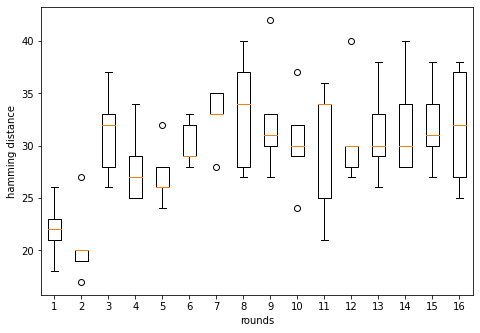

In [2]:
import uuid
import matplotlib.pyplot as plt

def get_ham_dis(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))


key = str(uuid.uuid4())[0:8]

data = []
for i in range(6):
    text = str(uuid.uuid4())[0:8]
    cipher = des(key)
    cipher.encrypt(text)
    data.append(cipher.rounds)

ham_distances = []
for i in range(16):
    dist = []
    for j in range(5):
        stable = data[5][i]
        round_text = data[j][i]
        dist.append(get_ham_dis(stable, round_text))
    ham_distances.append(dist)


fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('rounds')
ax.set_ylabel('hamming distance')
# Create the boxplot
bp = ax.boxplot(ham_distances)
plt.show()


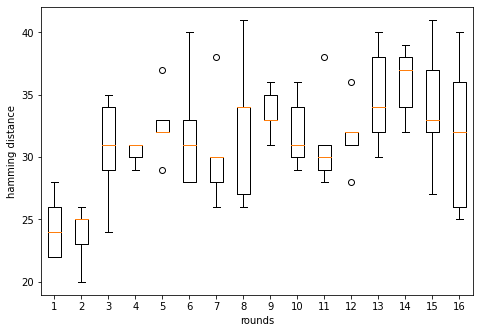

In [3]:
import uuid
import matplotlib.pyplot as plt

key = str(uuid.uuid4())[0:8]
stable_text = str(uuid.uuid4())[0:8]

data = []
distance = {}
for i in range(6):
    text = str(uuid.uuid4())[0:8]
    data.append(text)
    distance[text]=get_ham_dis(text,stable_text)

    
data=sorted(data, key=distance.__getitem__)
data.append(stable_text)

for i in range(6):
    cipher = des(key)
    cipher.encrypt(data[i])
    data[i]=cipher.rounds

ham_distances = []
for i in range(16):
    dist = []
    for j in range(5):
        stable = data[5][i]
        round_text = data[j][i]
        dist.append(get_ham_dis(stable, round_text))
    ham_distances.append(dist)

fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('rounds')
ax.set_ylabel('hamming distance')
# Create the boxplot

bp = ax.boxplot(ham_distances)
plt.show()


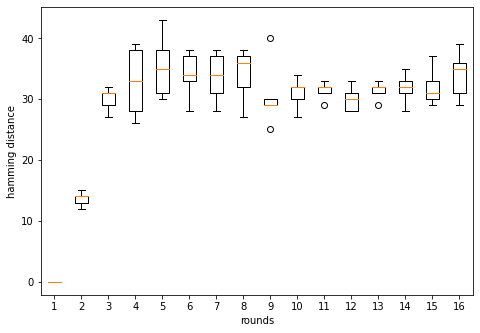

In [4]:
import numpy as np

stable_text = str(uuid.uuid4())[0:8]
rounds = []

for i in range(6):
    cipher = des(str(uuid.uuid4())[0:8])
    cipher.encrypt(stable_text)
    rounds.append(cipher.rounds)
    
    
ham_distances = []

for i in range(16):
    dist=[]
    for j in range(5):
        dist.append(get_ham_dis(rounds[j][i],rounds[5][i]))
   
    ham_distances.append(dist)

fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('rounds')
ax.set_ylabel('hamming distance')
# Create the boxplot
bp = ax.boxplot(ham_distances)
plt.show()